In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

from sim_handling2 import Simulation,loadSim
from diffusionstuff8 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

This notebook is to test where the 2d simulations lie on Nesh's previously made graph of the number of steady state steps on "Figure 11", a combination of the many parameters that influence growth.  

In [4]:
%matplotlib widget

In [35]:
 #set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (200,250), method='RK45')

test_2d_asym.discretization_halt = False

#try a noisy simulation
test_2d_asym.noisy_init = False

test_2d_asym.float_params['DoverdeltaX2'] *= 2 # raised to lower parameter product value
test_2d_asym.layermax = 
#test_2d_asym.sigmastepmax= -0.01 #ablation
test_2d_asym.sigmastepmax= 0.195 #growth - lowered to lower parameter product value
test_2d_asym.center_reduction = 0.025 *10
#test_2d_asym.center_reduction = 0.003 # lowered to lower parameter product value
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

In [36]:
#animate the simulation (runs if needed)
#test_2d_asym.run(halve_time_res=True) #only saves half the time steps since it is a huge simulation

anim = test_2d_asym.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

KeyboardInterrupt: 

In [37]:
#calculating Nss vs parameter thingy

# N_ss = # number of steps to steady state 
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity


#slope and intercept of linear fit of figure11 x to N_ss
#for sinusoidal growth
#M = 0.0027, B=2.9
#for parabolic growth
#M = 0.0025, B =1.6


def figure11(L,D,c_r,nu_kin,sigma):
    """
    L: length of domain, microns
    D: diffusion coefficient, microns^2 / microsecond
    c_r: center reduction, fraction
    nu_kin: growth rate, microns / second
    sigma: supersaturation at corner, fraction
    """
    beta = 0.65
    return nu_kin*L**2*sigma*(c_r)**beta / D

Lx,Ly = test_2d_asym.shape # num points
sigma = test_2d_asym.sigmastepmax
beta = 0.65 #value from paper 
nu_kin = AssignQuantity(test_2d_asym._extra_vars.get('nu_kin'), 'micron/second') #microns /second
D = AssignQuantity(test_2d_asym._extra_vars.get('D'),'micron^2 / microsecond')

#min values from paper
Lx_mu = AssignQuantity(17.5,'microns')
D = AssignQuantity(0.75E-4,'microns^2 / microsecond')
c_r = 0.15/100
nu_kin = AssignQuantity(20,'microns/second')
sigma = 0.20

print('Lx,Ly',Lx,Ly)
print('sigma',sigma)
print('beta',beta)
print('nu_kin',nu_kin)
print('D',D)
print('c_r',c_r)

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print('x with min values from paper: ',x)


#max values from paper
Lx_mu = AssignQuantity(42.5,'microns')
D = AssignQuantity(6E-4,'microns^2 / microsecond')
c_r = 0.7/100
nu_kin = AssignQuantity(140,'microns/second')
sigma = 0.50

print('Lx,Ly',Lx,Ly)
print('sigma',sigma)
print('beta',beta)
print('nu_kin',nu_kin)
print('D',D)
print('c_r',c_r)

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print('x with max values from paper: ',x)

Lx,Ly 200 250
sigma 0.2
beta 0.65
nu_kin 20 micron / second
D 7.5e-05 micron ** 2 / microsecond
c_r 0.0015
x with min values from paper:  0.23852513136020506 micron
Lx,Ly 200 250
sigma 0.5
beta 0.65
nu_kin 140 micron / second
D 0.0006 micron ** 2 / microsecond
c_r 0.006999999999999999
x with max values from paper:  8.376032923384129 micron


In [34]:
#calculating parameterization produce (fig 11) for simulation
Lx,Ly = test_2d_asym.shape # num points
sigma = test_2d_asym.sigmastepmax
beta = 0.65 #value from paper 
nu_kin = AssignQuantity(test_2d_asym._extra_vars.get('nu_kin'), 'micron/second') #microns /second
D = AssignQuantity(test_2d_asym._extra_vars.get('D'),'micron^2 / microsecond')
c_r = test_2d_asym.center_reduction

#min values from paper
Lx_mu = AssignQuantity(25,'microns')
Ly_mu = Ly/Lx * Lx_mu

x = figure11(Lx_mu,D,c_r,nu_kin,sigma)
x.ito('microns')
print(x)

0.6842416852072563 micron


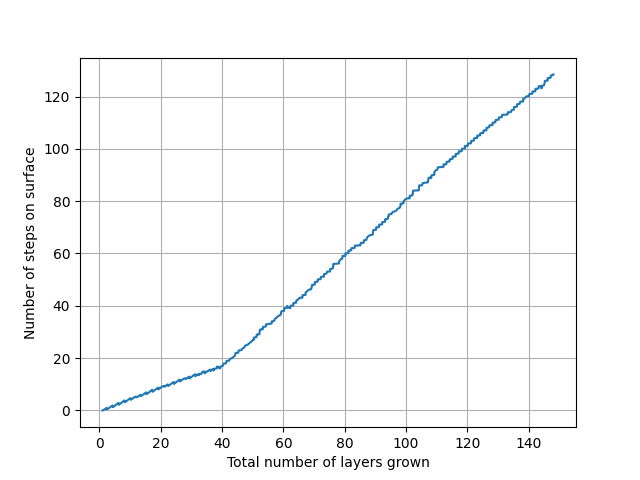

In [38]:
#graph number of steps over time
Ntot = test_2d_asym.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if test_2d_asym.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+test_2d_asym.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()

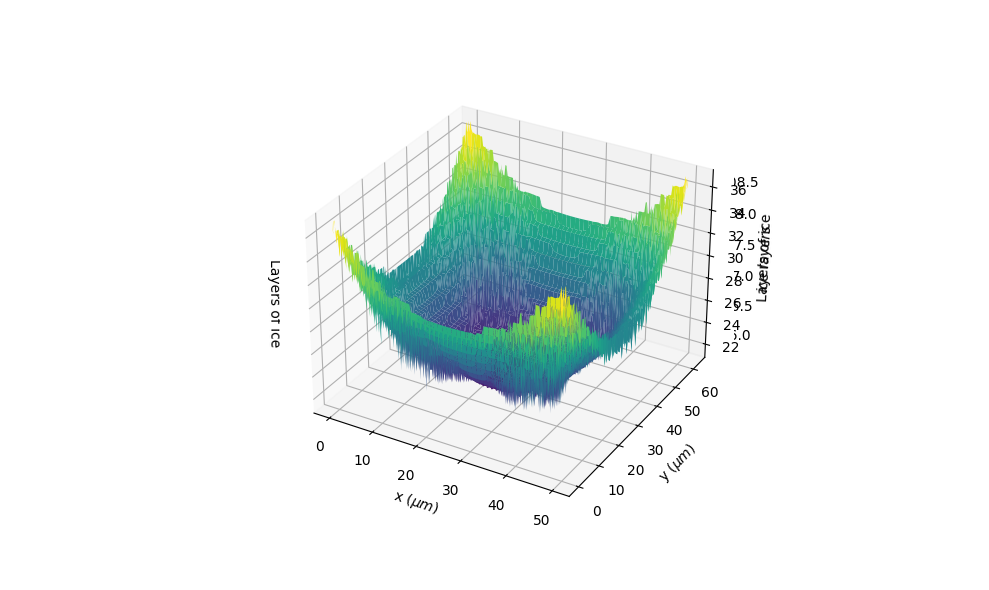

In [41]:
#plot surface at middle and end of simulation
plot = test_2d_asym.plot(ice=True,completion=0.2)


In [40]:
plt.close()

In [9]:
#continuation of previous simulation
#start a second simulation starting with the ending surface of the first 
# as the initial surface

#create 1d sim and graph number of steps over time
cycle_sim =  Simulation(f2d, (test_2d_asym.shape[0],test_2d_asym.shape[1]), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

#keep general params same
cycle_sim.layermax = 1000 #st_2d_asym.layermax * 1.5 #make sure it reaches steady state
cycle_sim.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
cycle_sim.sigma0 = test_2d_asym.sigma0
cycle_sim.center_reduction = test_2d_asym.center_reduction
cycle_sim.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
cycle_sim.noisy_init = test_2d_asym.noisy_init

#set up initial surface
cycle_sim.nonstd_init = True
ntots = test_2d_asym.getNtot()
cycle_sim.startingNtot = ntots[len(ntots)//2] #start with the middle of the last simulation, before discretzation error

#set to ablation run
cycle_sim.sigmastepmax = 0.20 


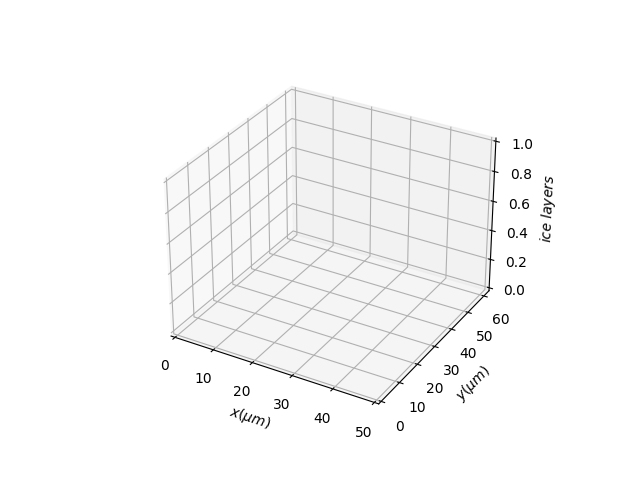

In [10]:
#animate ablation of growth ending surface
anim = cycle_sim.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

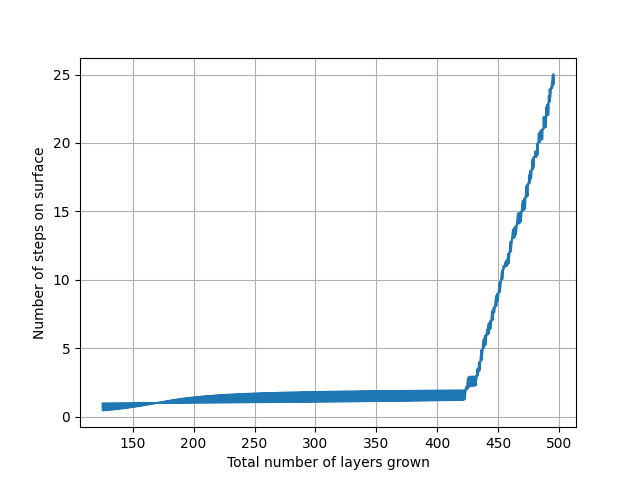

In [11]:
#graph number of steps over time for second simulation
Ntot = cycle_sim.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if cycle_sim.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+cycle_sim.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()